In [1]:
#input necessary packages here

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

#wrf packages
import wrf
from wrf import (to_np, interplevel, geo_bounds, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, getvar, CoordPair, vertcross, ll_to_xy, xy_to_ll)

#to read in data
import glob
import matplotlib.pyplot as plt

#for some fun math
import math
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from netCDF4 import Dataset, num2date, date2num
from scipy.ndimage import gaussian_filter
import pandas as pd

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#New Color Scale for IR Brightness
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

#Creating IR color Scale
def make_Ramp( ramp_colors ):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ["#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
                          "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
                          "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
                          "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
                          "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
                          "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
                          "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
                          "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
                          "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
                          "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
                          "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
                          "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
                          "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
                          "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
                          "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
                          "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
                          "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
                          "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
                          "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
                          "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
                          "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
                          "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
                          "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
                          "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
                          "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
                          "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
                          "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
                          "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
                          "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
                          "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
                          "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
                          "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
                          "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
                          "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
                          "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
                          "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
                          "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
                          "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
                          "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
                          "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
                          "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
                          "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
                          "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
                          "#fffef1","#fffef4","#fffff6"]) 

top = custom_ramp
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0,1,66)), 
                     bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name = 'Cam_Cool_Color_Scale')

In [ ]:
'''
Psuedo code:

if time step = 10:
1. find the minimum central pressure of the previous time steps
2. plot those pressure fields 
3. overlay IR on top of it
4. To the right have a time series of pressure and velocity!
'''

In [3]:
#first, we need to loop through all the files to find the pressures from each and plot them!
filepath = '/Users/cjmasiel/Desktop/Anantha_Final/real_plane/wrfout_d02_files/wrfout_d02*'  #For ncar files
datafiles = sorted(glob.glob(filepath))

In [4]:
pressure_tc = []
lat_tc = []
lon_tc = []
wind_max = []
dates = []

for item in range(0,len(datafiles)-1):
    ncfile = Dataset(datafiles[item])
    wrf_out_data = xr.open_dataset(datafiles[item])   
   
    #First, lets find the data data assocaited with all of them
    time = wrf_out_data['XTIME'][0].values
    time_changed = time.astype(np.datetime64)
    ts = pd.to_datetime(str(time_changed))
    d = ts.strftime('%m-%d %H:%M')
    dates.append(d)
    
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    minp_smoothed = minpressure_smoothed

    #Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]
    
    #Cool! we have the smoothed pressure field center, so we will use this to now back out 
    #the minimum pressure at this location
    
    min_p = P_pertubation[0,0,s_n_smoothed,w_e_smoothed]
    background_p = wrf_out_data['PB'][0,0,s_n_smoothed,w_e_smoothed]
    
    #append lat/long infomation
    lon_tc.append(wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values)
    lat_tc.append(wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values)
    
    #append pressure information
    pressure_tc.append(((min_p.values + background_p.values) / 100))
    ###############################################################################################
    #next, we will find wind information
    lat = wrf_out_data['XLAT'][0,:,:]
    lon = wrf_out_data['XLONG'][0,:,:]

    nx = lat.shape[0]
    ny = lat.shape[1]
    
    uvmet10 = getvar(ncfile,"uvmet10")
    u10 = uvmet10[0].values
    v10 = uvmet10[1].values

    wind_10_abs  = np.zeros([nx,ny])
    
    wind_10_abs[:,:] = np.sqrt(u10[:,:]**2 + v10[:,:]**2)
    max_value = np.max(wind_10_abs)
    wind_max.append(max_value)

In [5]:
print(pressure_tc)
print(wind_max)

[1010.960703125, 1003.949296875, 1004.917265625, 1003.812578125, 1000.579375, 999.391171875, 993.320234375, 994.01734375, 990.77234375, 986.4234375, 982.915078125, 977.291328125, 975.97046875, 972.42515625, 969.804609375, 967.7303125, 963.708984375, 961.241328125, 958.623671875, 955.599453125, 953.056953125, 948.612890625, 947.311640625, 946.588125, 946.495859375, 945.57859375, 944.396796875, 943.80875, 943.234765625, 940.266015625, 938.723828125, 936.056015625, 933.4746875, 932.054375, 932.1475, 931.97515625, 929.73015625, 930.54921875, 928.448125, 928.100546875, 927.295859375, 927.074140625, 924.09515625, 923.183359375, 922.788828125, 922.310078125, 921.0365625, 920.490234375, 919.661015625, 917.569609375, 916.9084375, 916.33421875, 915.56234375, 915.1703125, 914.97125, 916.120703125, 916.01953125, 915.61953125, 914.2971875, 912.607109375]
[0.0, 21.993770599365234, 23.22311019897461, 23.319002151489258, 25.306507110595703, 26.976806640625, 28.624176025390625, 30.31729507446289, 33.23

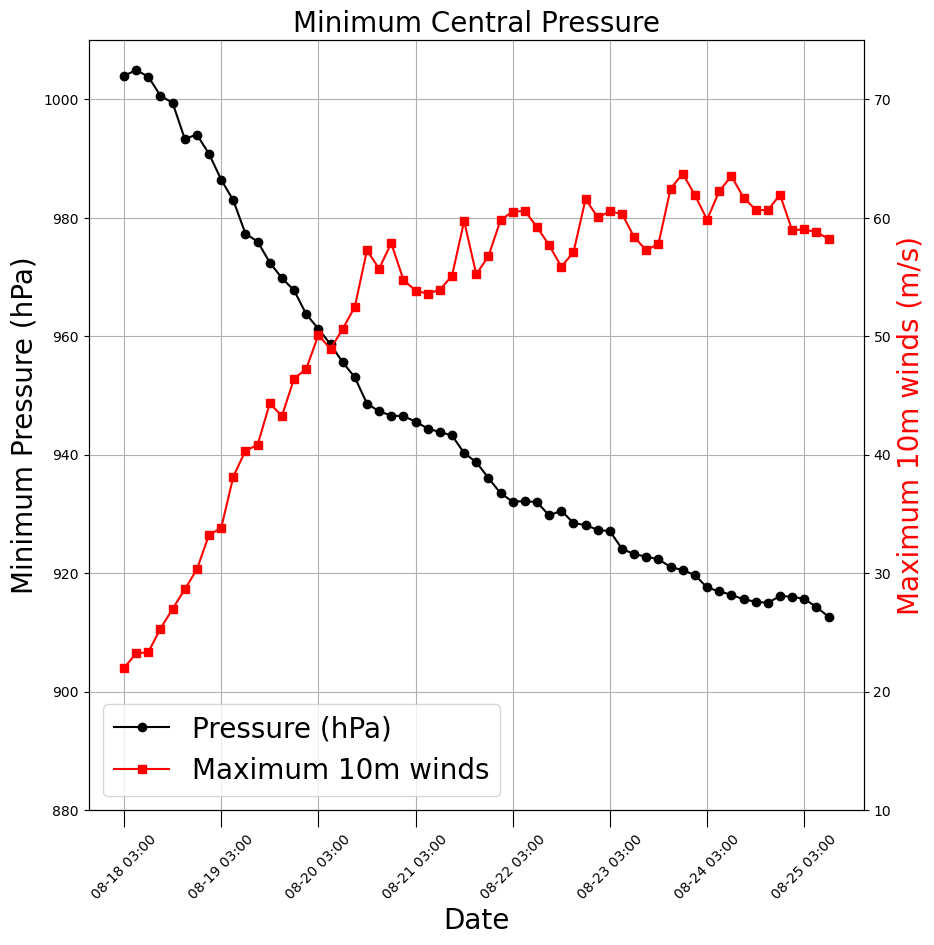

In [6]:
fig= plt.figure(figsize=(10,10))

# Plotting the first line
ax1 = fig.add_subplot(111)
line1 = ax1.plot(dates[1:], pressure_tc[1:], "-o", color='black', label="Pressure (hPa)")

# Show every third x-tick label
every_nth = 8
ax1.set_xticks(dates[1::every_nth])  # Set x-ticks to every third date

# Rotate x-ticks for better readability and set font size
ax1.tick_params(axis='x', rotation=45, size=12)

ax1.set_xlabel("Date", size=20)
ax1.set_ylabel("Minimum Pressure (hPa)", size=20)
ax1.set_title("Minimum Central Pressure", size=20)
ax1.set_ylim([880, 1010])
ax1.grid(True)
#ax1.legend(fontsize="20")

# Adding a twin y-axis to plot the second variable
ax2 = ax1.twinx()
line2 = ax2.plot(dates[1:], wind_max[1:], "-s", color='red', label = "Maximum 10m winds")  # "-s" is for square markers
ax2.set_ylabel("Maximum 10m winds (m/s)", color='red', size=20)
ax2.set_ylim([10, 75])
#ax2.legend(fontsize="20")

# Creating a combined legend
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize="20", loc = "lower left")

plt.show()

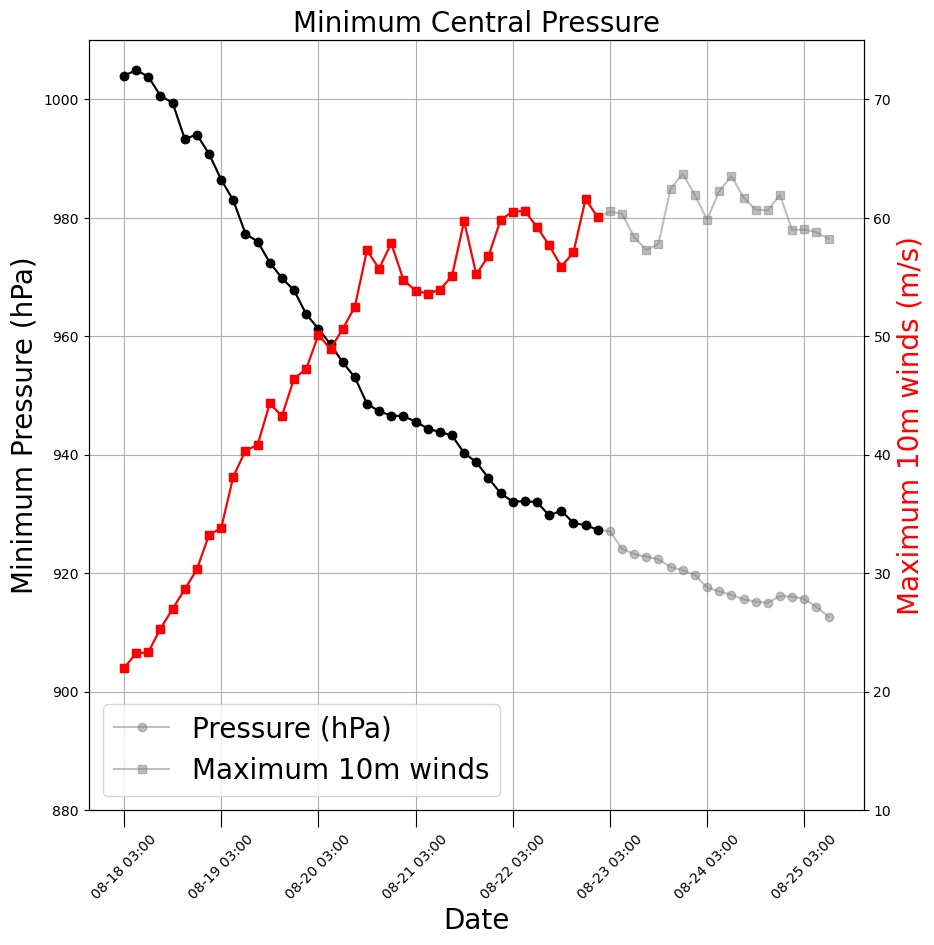

In [7]:
fig= plt.figure(figsize=(10,10))

# Plotting the first line
ax1 = fig.add_subplot(111)

line1 = ax1.plot(dates[1:], pressure_tc[1:], "-o", 
                 color='grey',
                 alpha = 0.5,
                 label="Pressure (hPa)")

# Show every third x-tick label
every_nth = 8
ax1.set_xticks(dates[1::every_nth])  # Set x-ticks to every third date

# Rotate x-ticks for better readability and set font size
ax1.tick_params(axis='x', rotation=45, size=12)

ax1.set_xlabel("Date", size=20)
ax1.set_ylabel("Minimum Pressure (hPa)", size=20)
ax1.set_title("Minimum Central Pressure", size=20)
ax1.set_ylim([880, 1010])
ax1.grid(True)
#ax1.legend(fontsize="20")

# Adding a twin y-axis to plot the second variable
ax2 = ax1.twinx()

line2 = ax2.plot(dates[1:], wind_max[1:], "-s", 
                 color ='grey',
                 alpha = 0.5,
                 label = "Maximum 10m winds")  

ax2.set_ylabel("Maximum 10m winds (m/s)", color='red', size=20)
ax2.set_ylim([10, 75])

# Creating a combined legend
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, fontsize="20", loc = "lower left")

for i in range(41,42):
    line1 = ax1.plot(dates[1:i], pressure_tc[1:i], "-o", 
                 color='black',
                 alpha = 1)
    
    line2 = ax2.plot(dates[1:i], wind_max[1:i], "-s", 
                 color ='red',
                 alpha = 1)  
    
plt.show()

In [8]:
#only run the cell below for the 1.33 kilometer inner nest

#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon, tclat, ax=None):
    tclon5a = 5 * (int(tclon / 5) - 1)
    tclon5b = 5 * (int(tclon / 5))
    tclat5a = 5 * (int(tclat / 5) - 1)
    tclat5b = 5 * (int(tclat / 5))

    if ax is None:
        fig = plt.figure(figsize=(15, 15))
        ax = plt.subplot(111, projection=ccrs.PlateCarree())
    else:
        fig = None

    ax.set_extent([tclon - 5, tclon + 5, tclat - 5, tclat + 5], ccrs.PlateCarree())
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a - 10, tclon5a - 5, tclon5a, tclon5b, tclon5b + 5, tclon5b + 10])
    gl.ylocator = mticker.FixedLocator([tclat5a - 10, tclat5a - 5, tclat5a, tclat5b, tclat5b + 5, tclat5b + 10])
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)

    return fig, ax

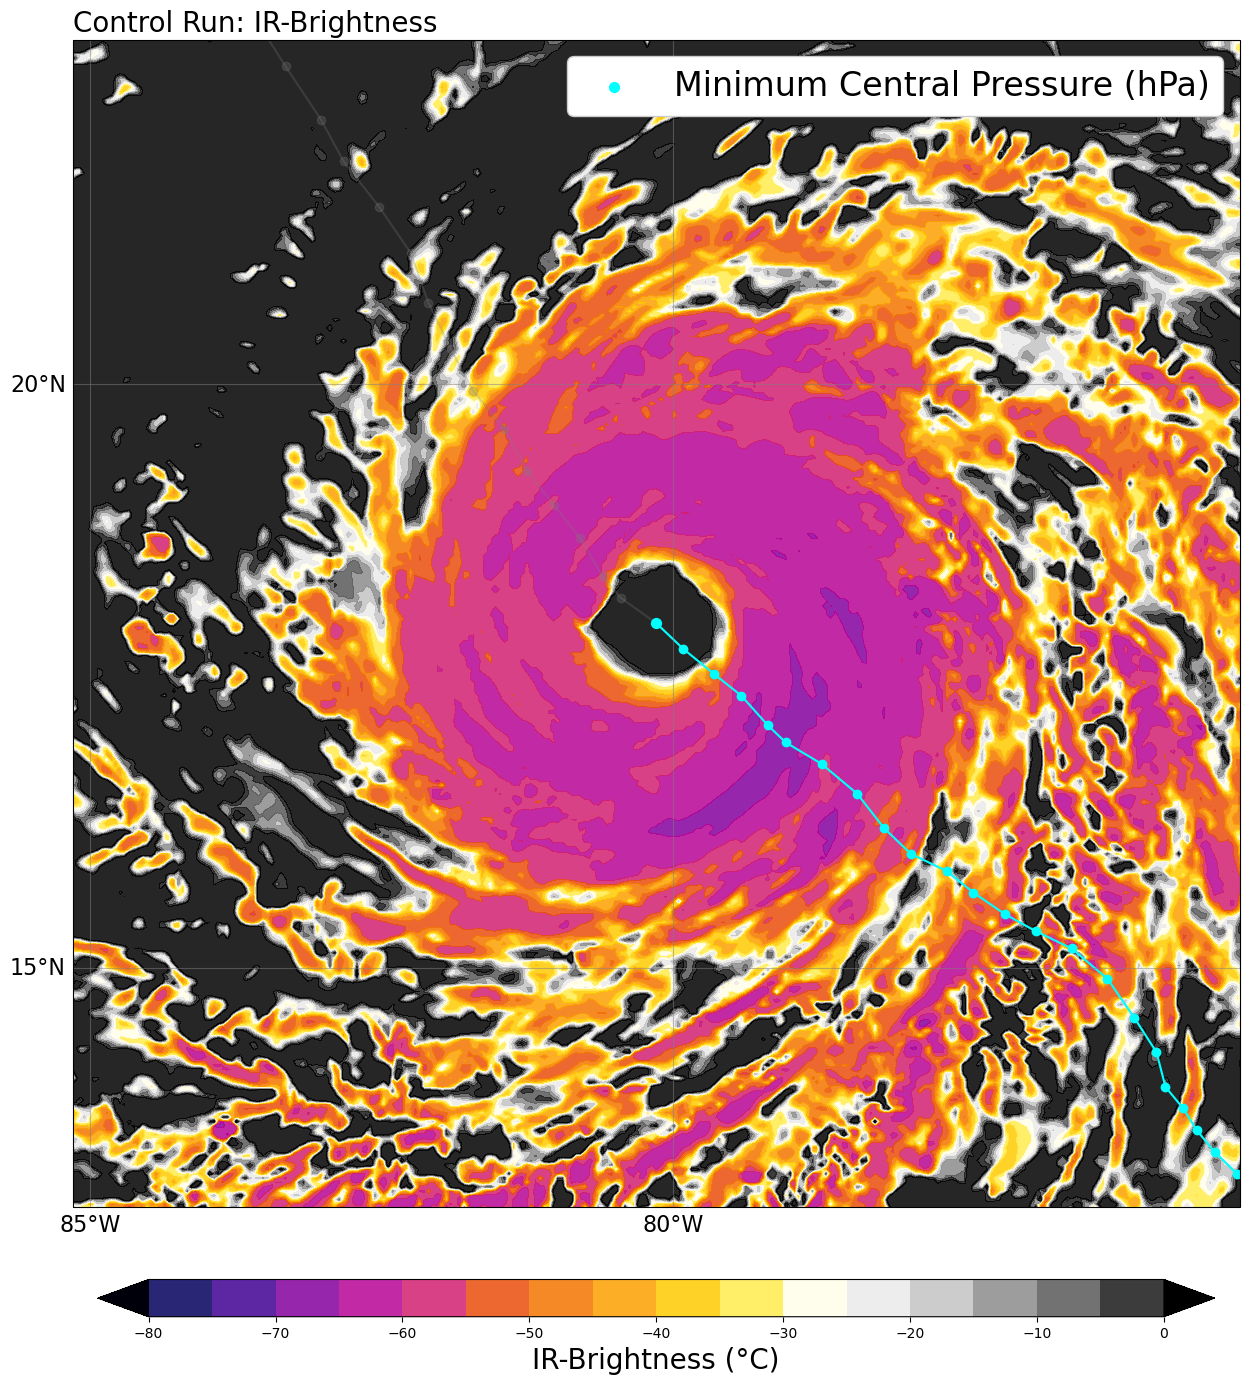

In [9]:
for item in range(33,34):
    ncfile = Dataset(datafiles[item])
    wrf_out_data = xr.open_dataset(datafiles[item])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, 
                             cache=None, meta=False, do_xtime=False)
    
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    #######################################################################################################
    #IR brightness temperature
    wrf_out_OLR = wrf_out_data['OLR'][0,:,:]
    lat_current = wrf_out_data['XLAT'][0,:,:]
    lon_current = wrf_out_data['XLONG'][0,:,:]
    
    IR_Brightness = -273.15 + (wrf_out_OLR.values + 310)/2
    #######################################################################################################
    fig, ax = create_map_background(tc_lon,tc_lat)
    
    #first, plot the whole lat_lon points on the map in grey:
    line1 = ax.plot(lon_tc[1:], lat_tc[1:], "-o", 
                 color = 'grey',
                 alpha = 0.25)
    
    line2 = ax.plot(lon_tc[1:item+1], lat_tc[1:item+1], "-o", 
                 color = 'cyan',
                 alpha = 1)
    
    plot = plt.contourf(lon_current, lat_current, IR_Brightness,
                        origin = 'lower', 
                        cmap = newcmp, 
                        levels = np.arange(-80, 5, 5), 
                        alpha = .85, 
                        extend ='both')
    
    plt.scatter(tc_lon, tc_lat, color='cyan', s=50, zorder=5, label = 'Minimum Central Pressure (hPa)')

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('IR-Brightness (°C)', fontsize = 20)
    
    plt.legend(loc='upper right', fontsize=24, framealpha=1)
 
    plt.title('Control Run: IR-Brightness', loc = 'left', fontsize = 20)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.show()
    plt.close()

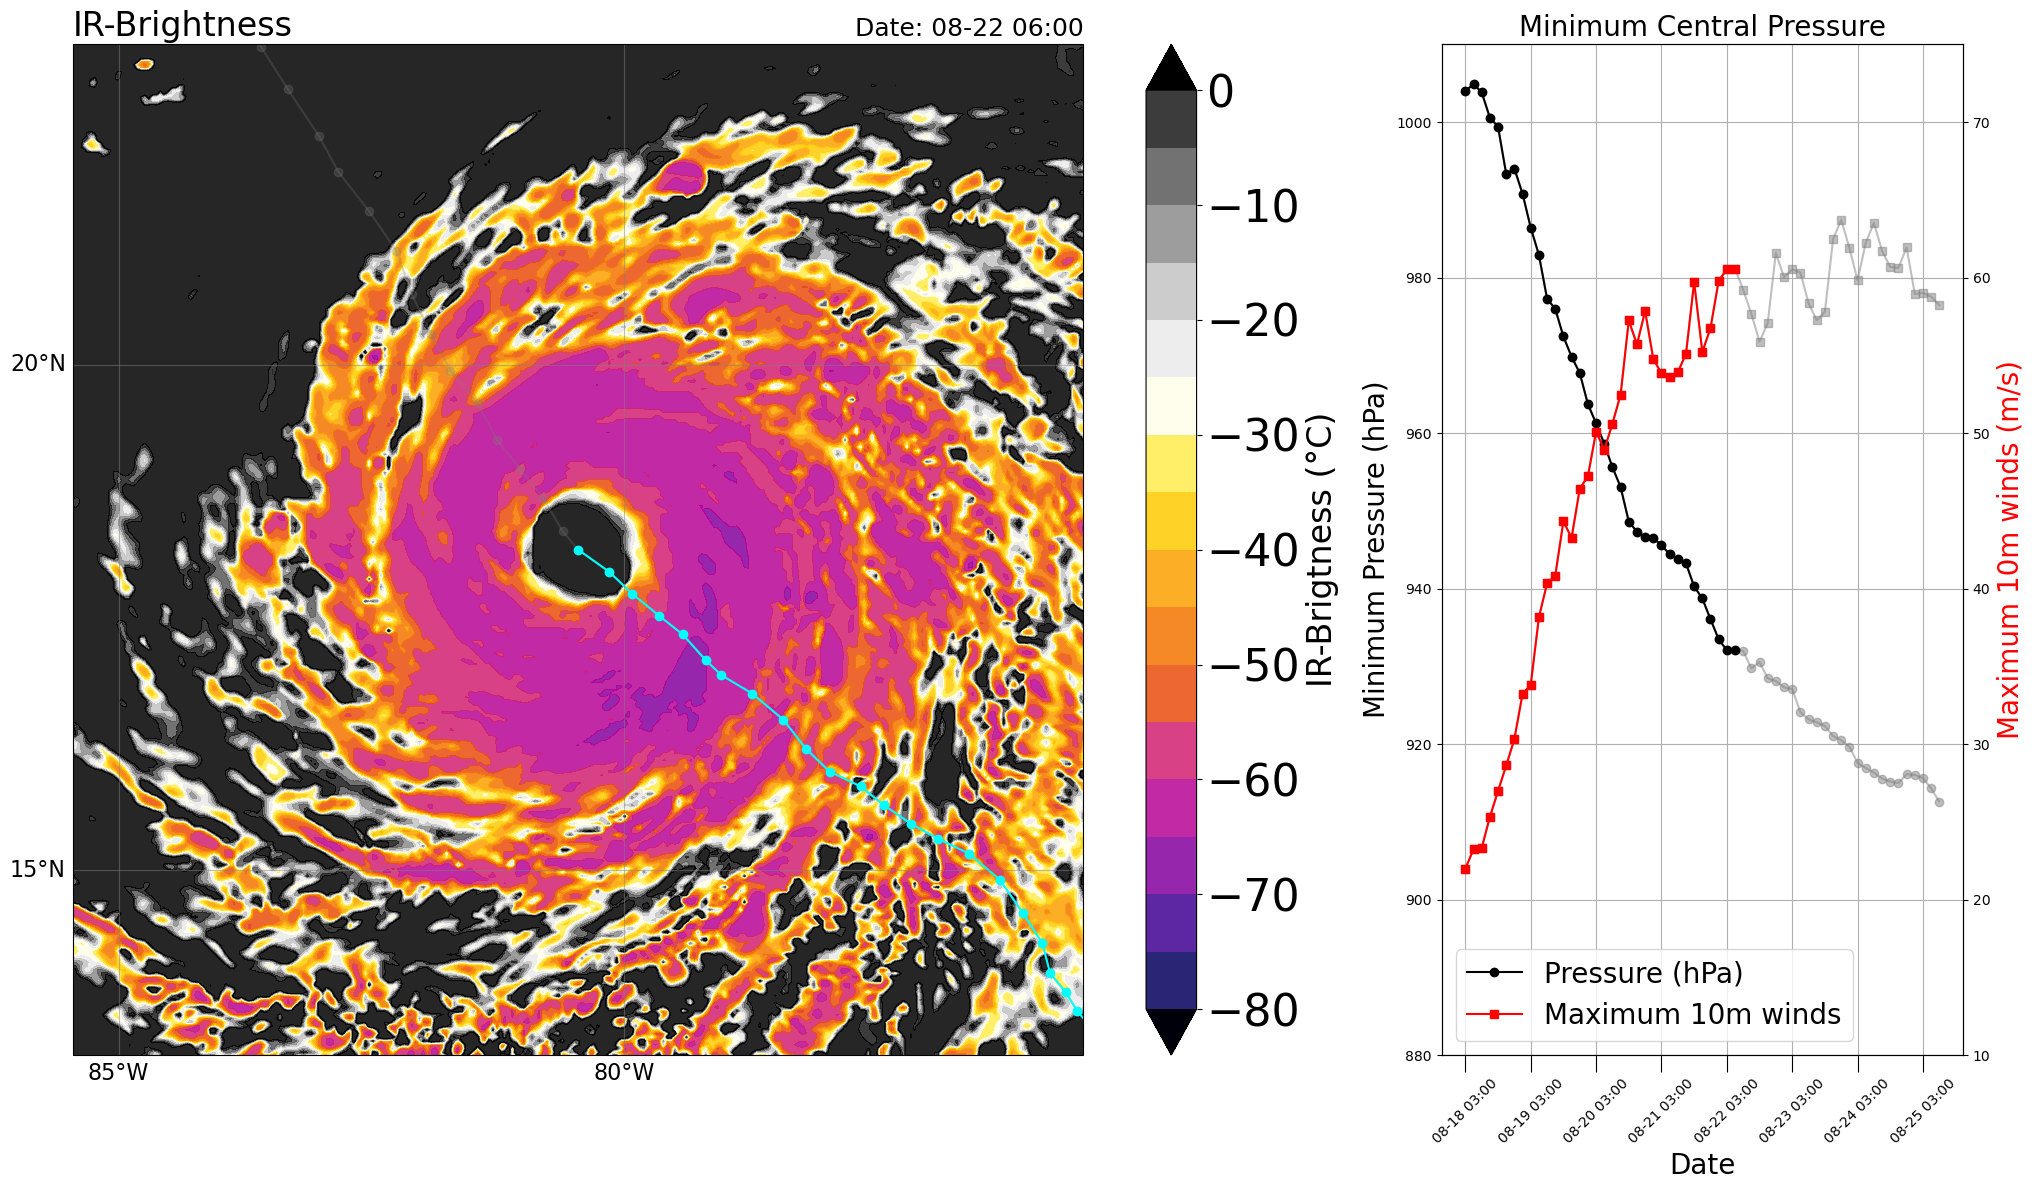

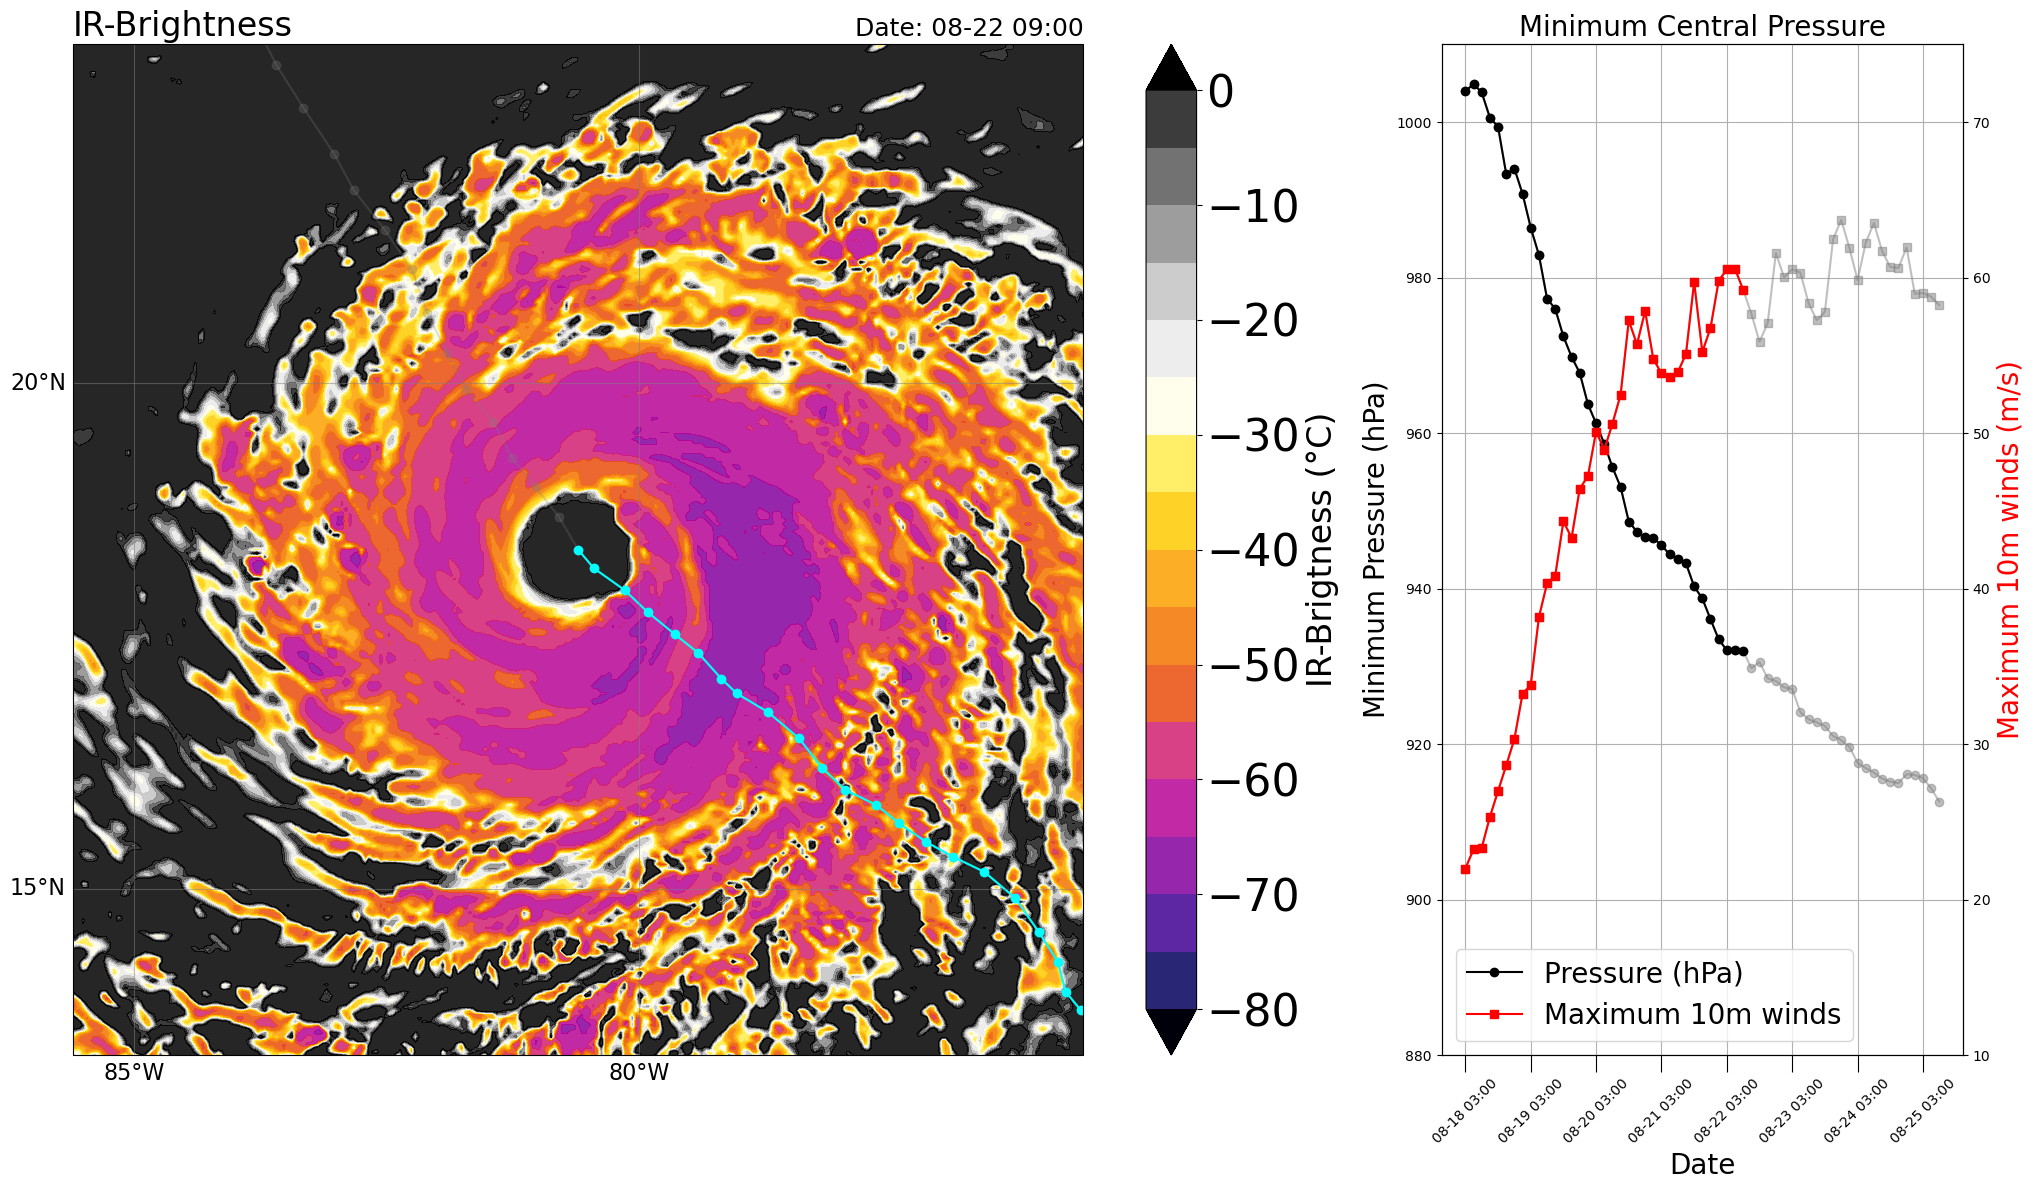

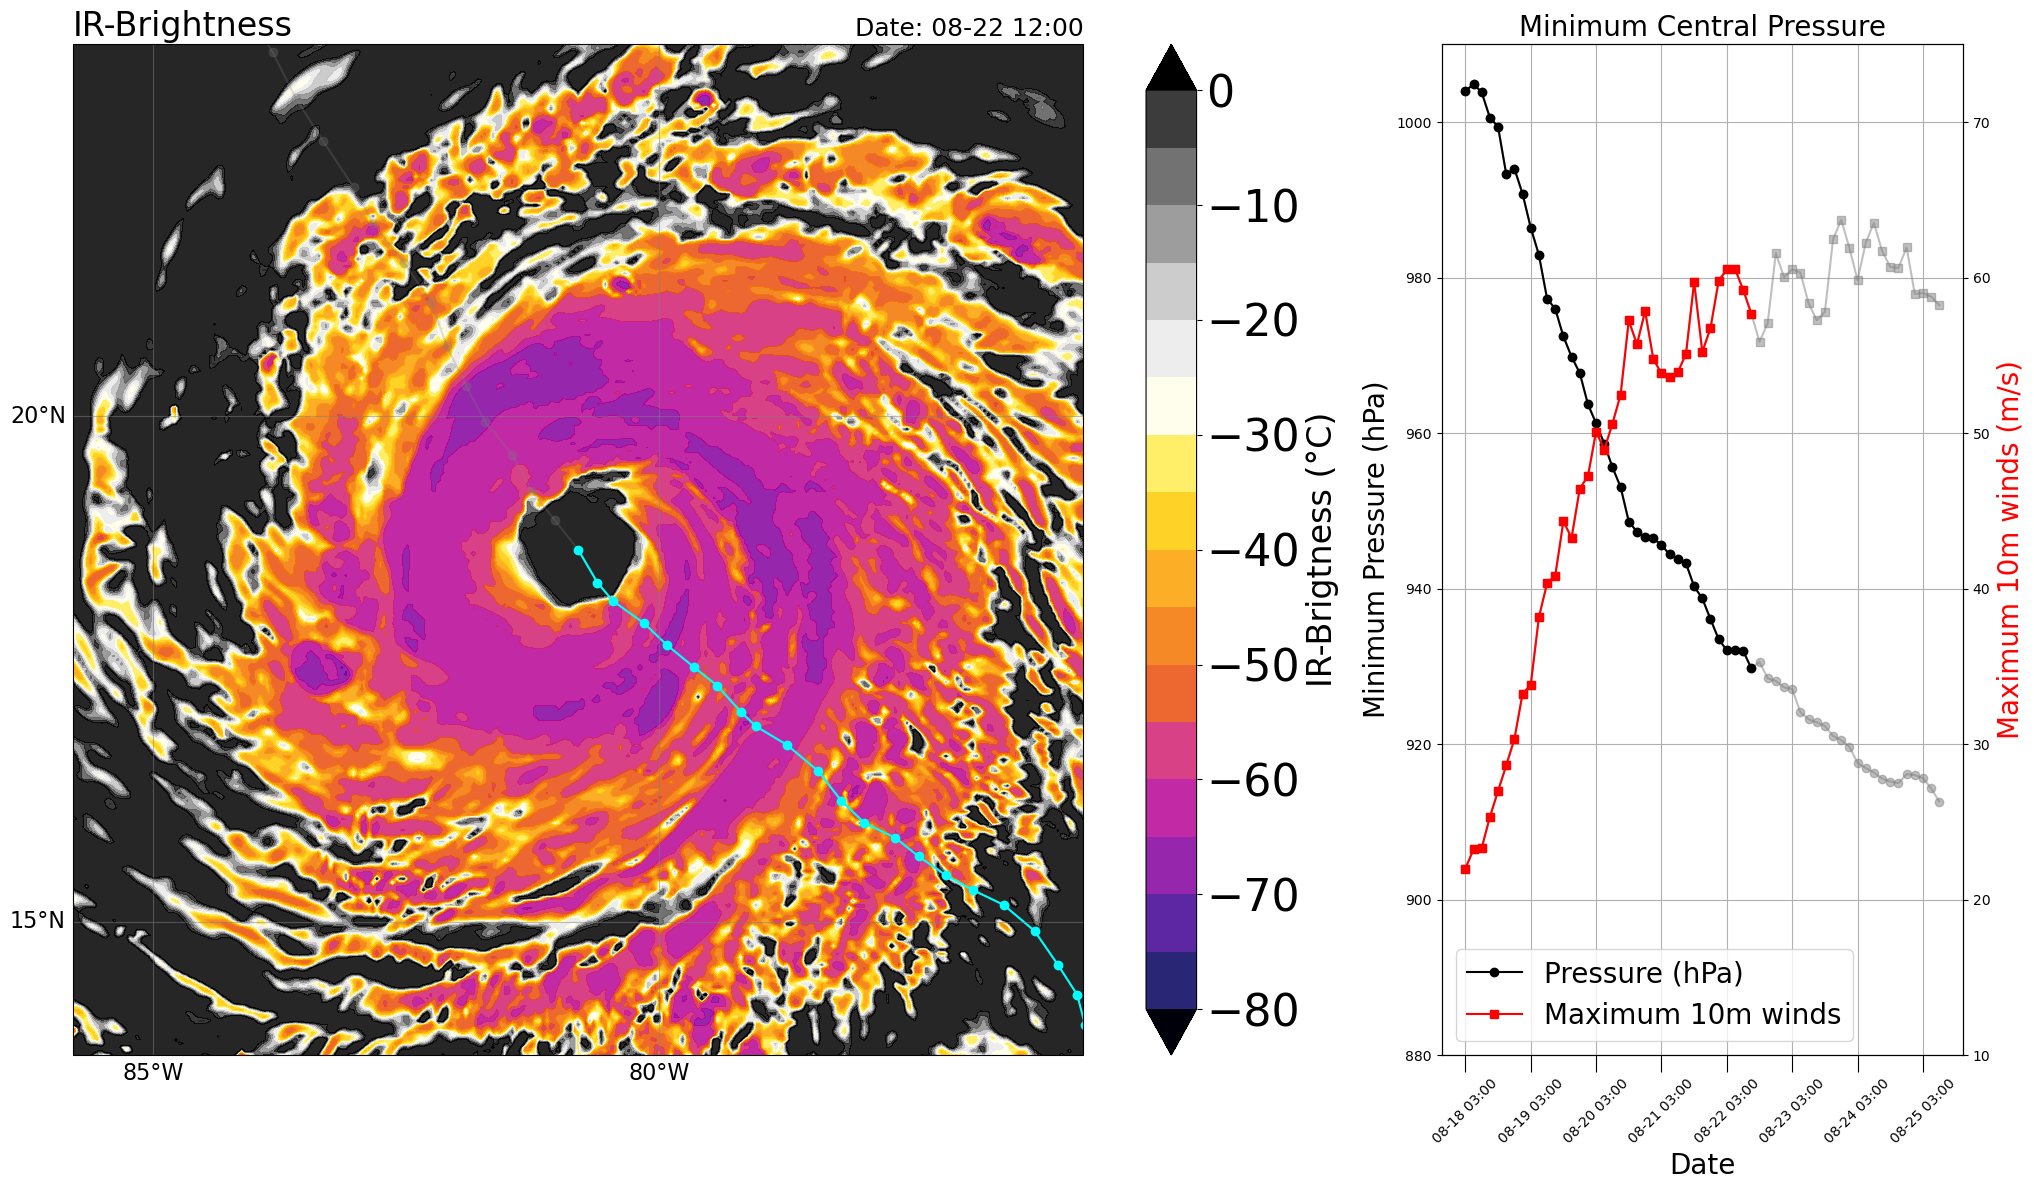

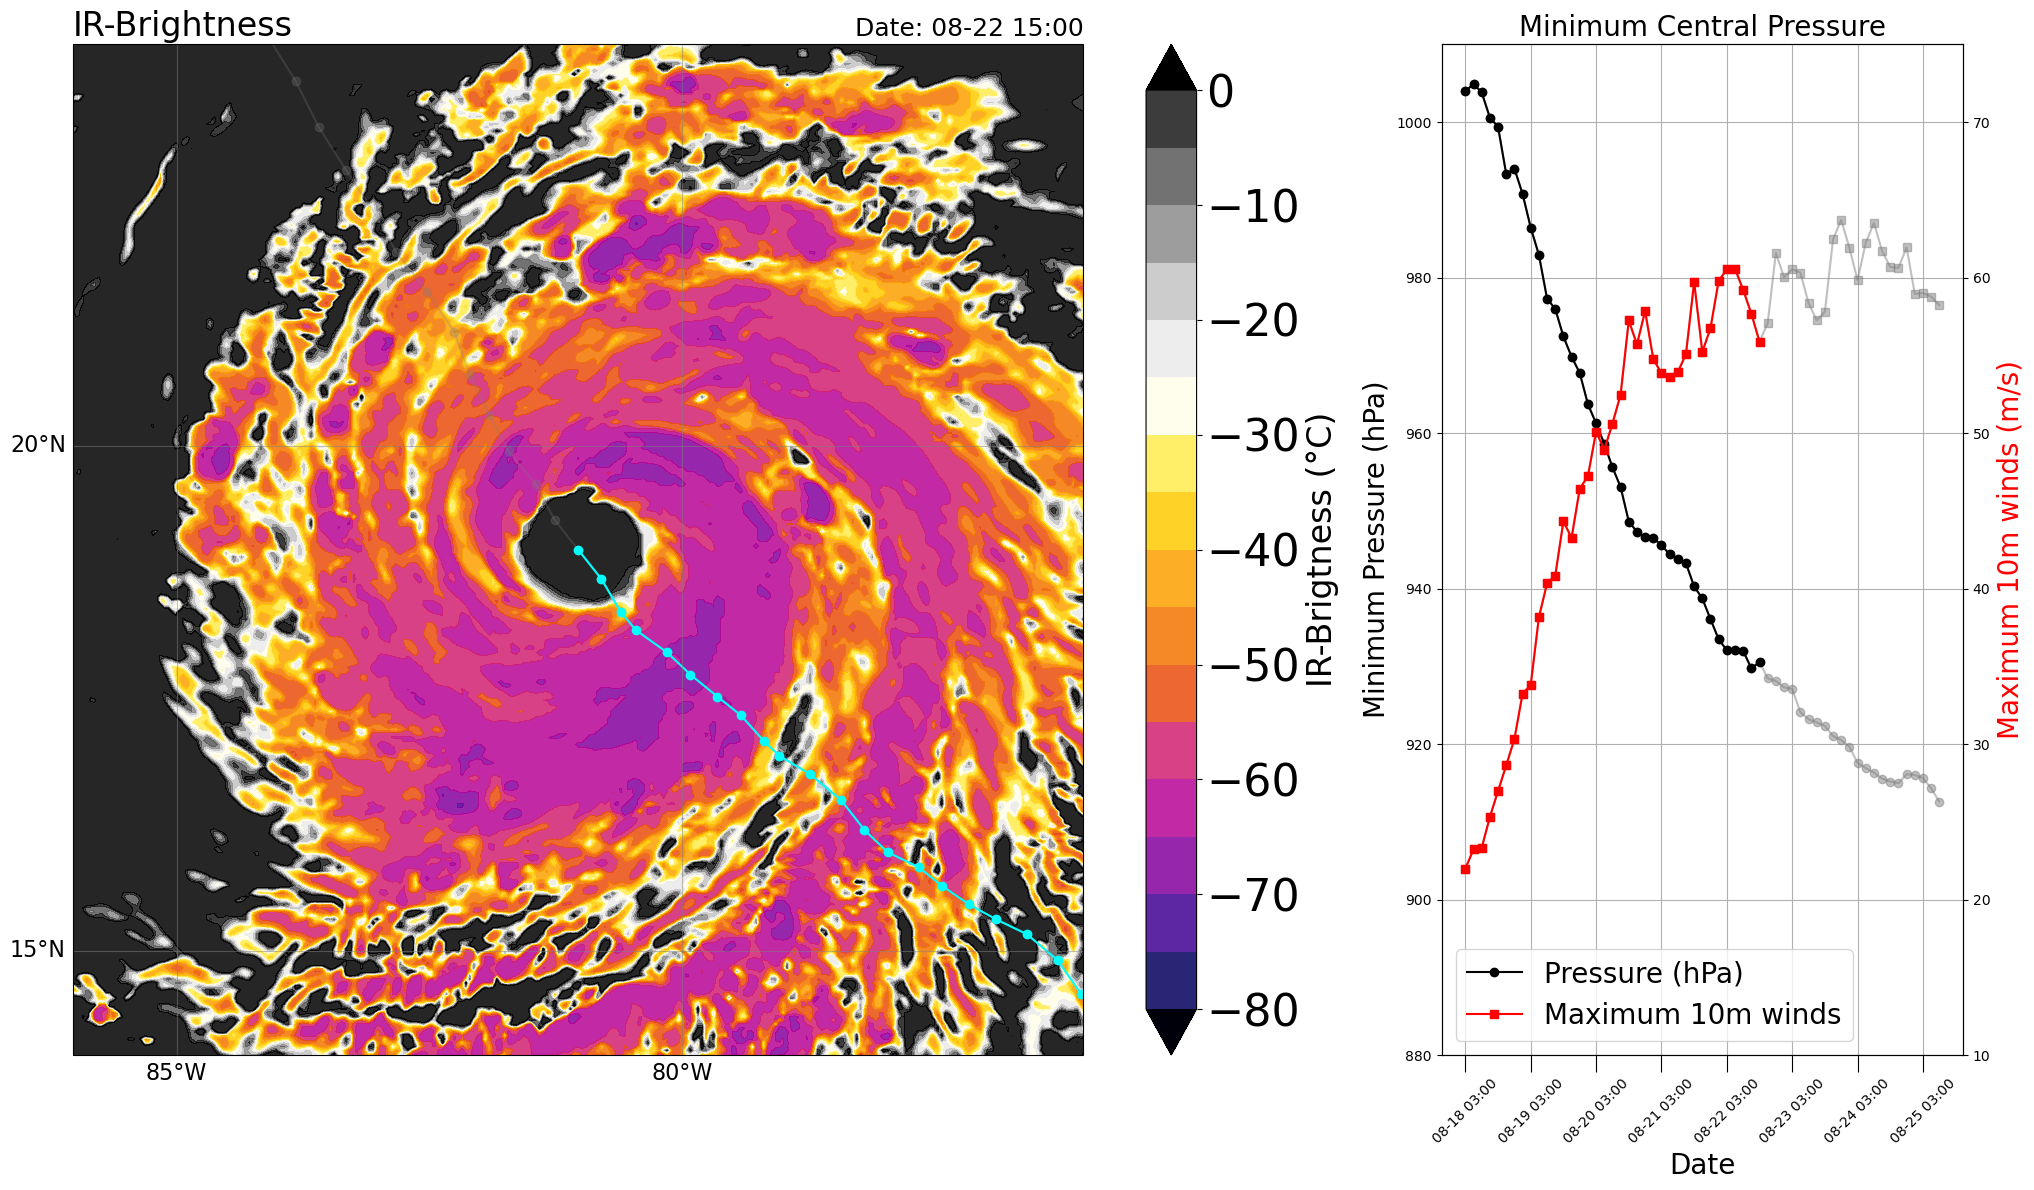

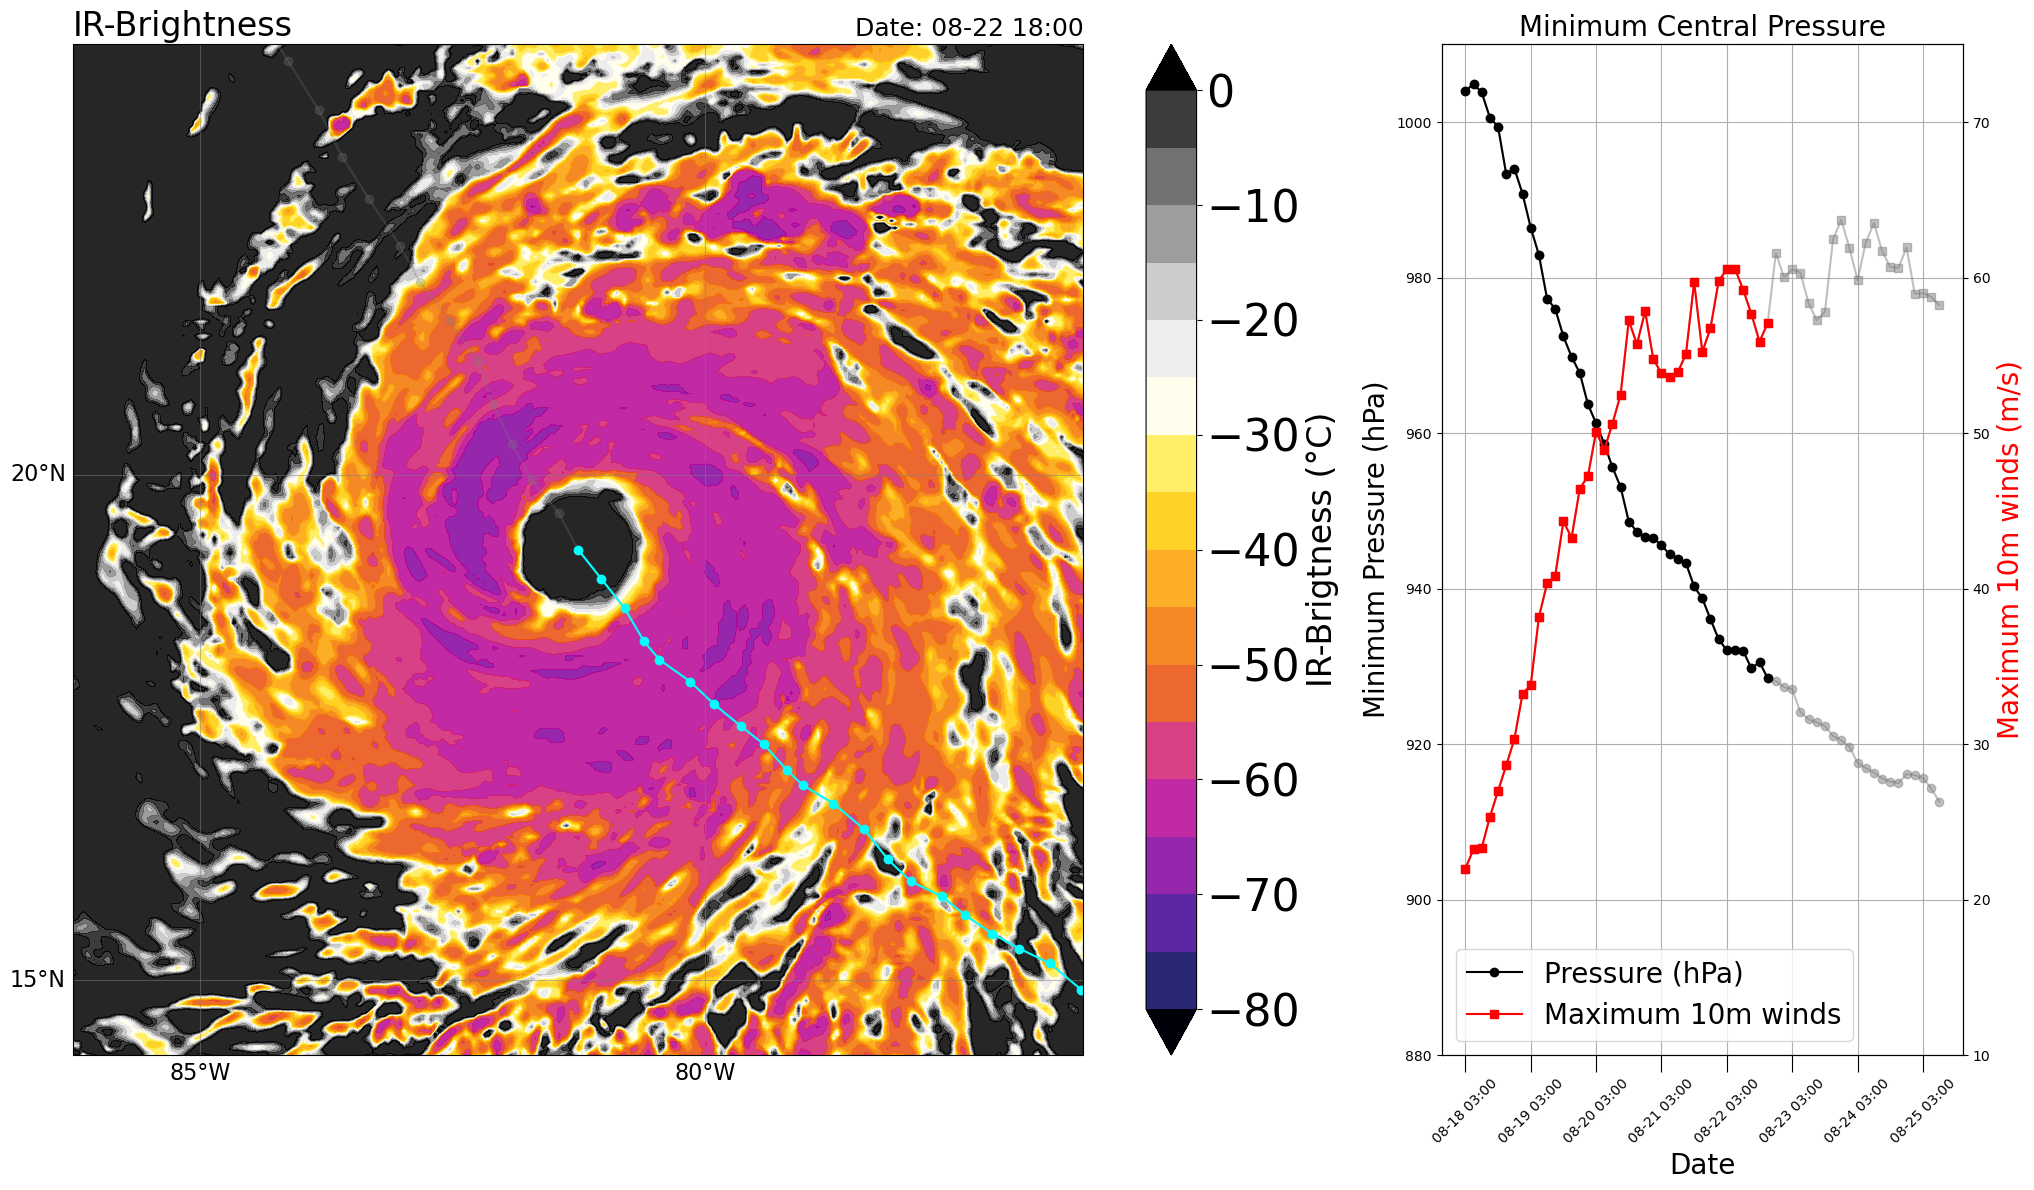

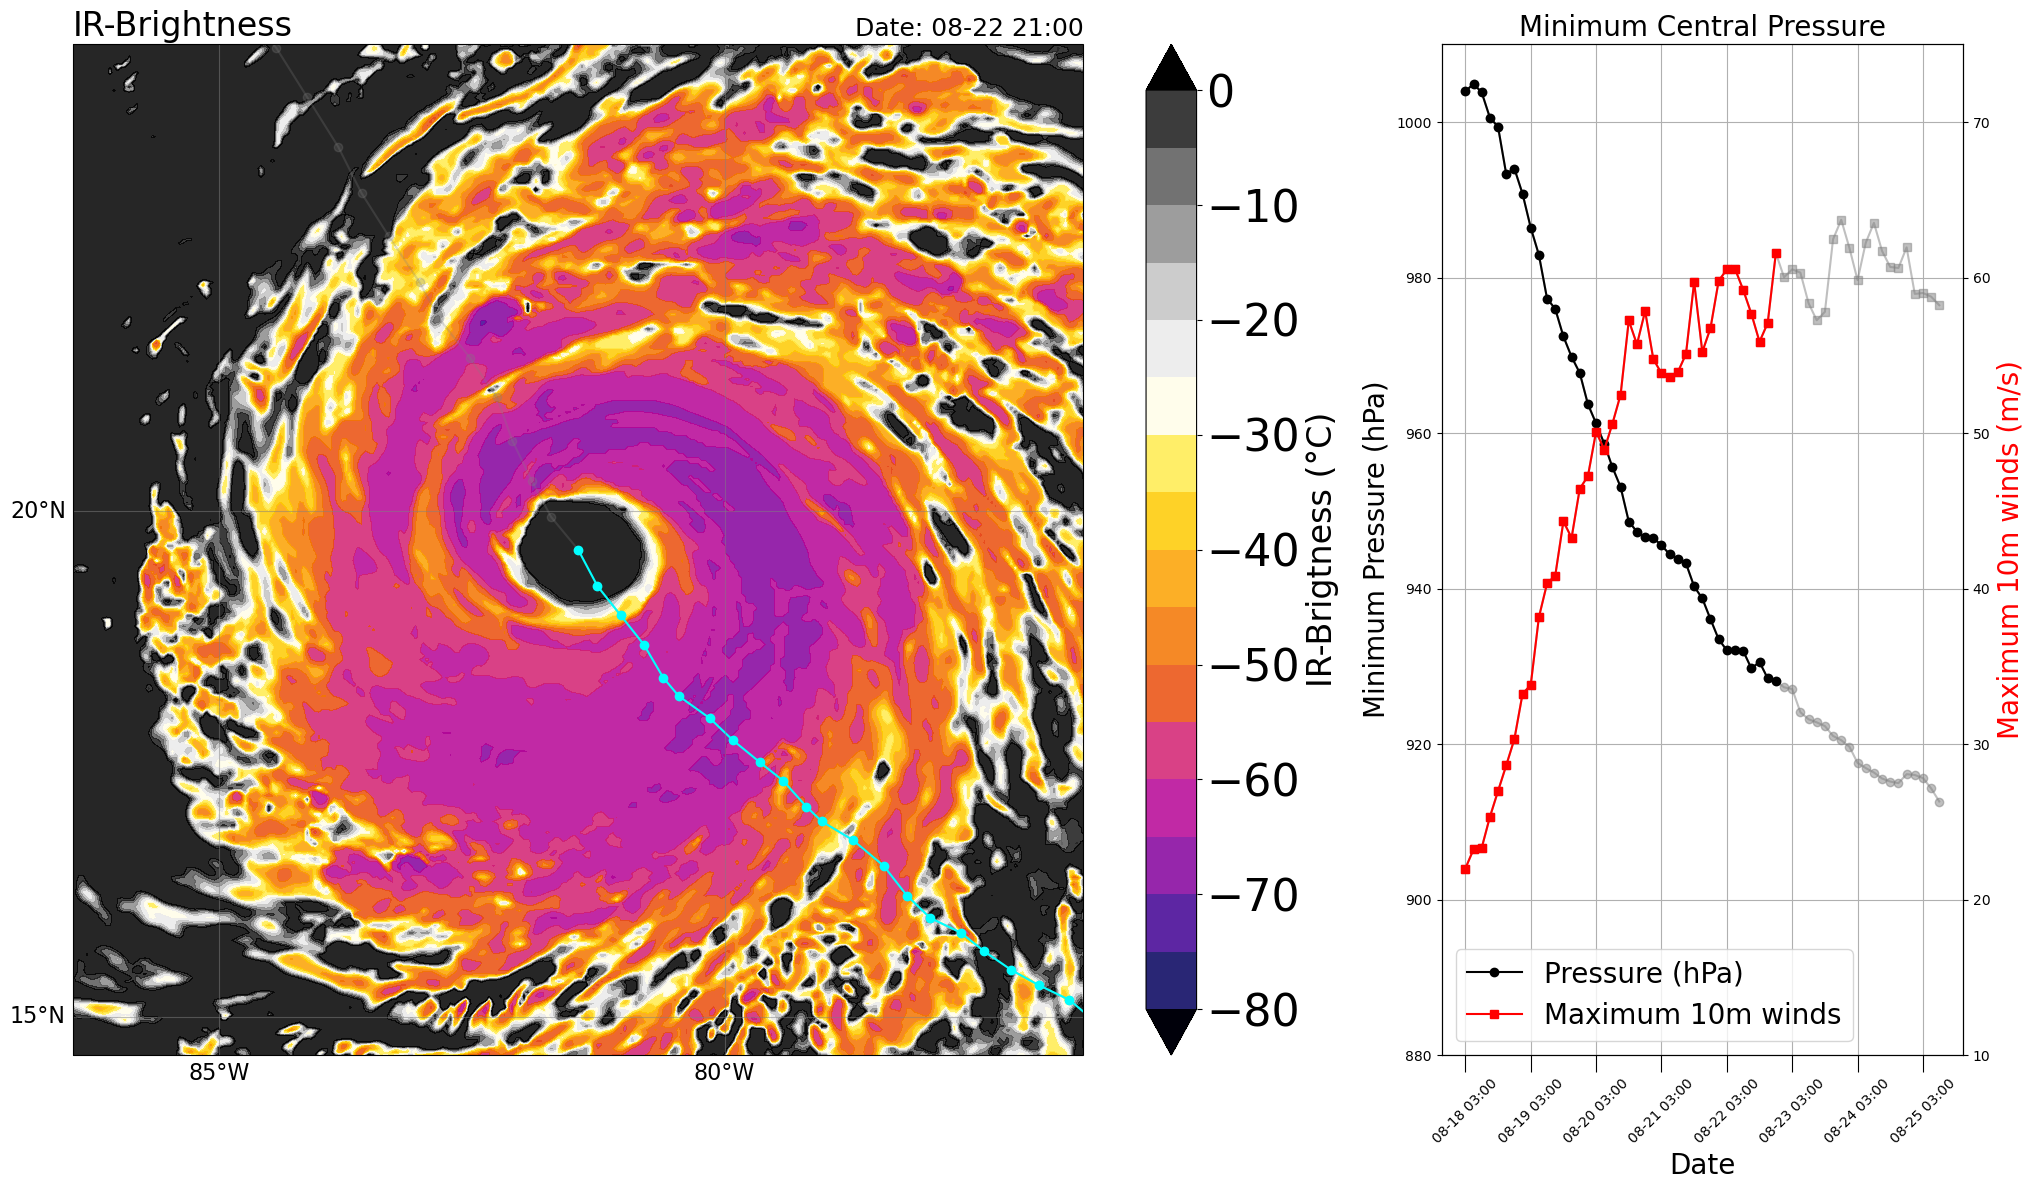

In [10]:
for item in range(34,40):
    ncfile = Dataset(datafiles[item])
    wrf_out_data = xr.open_dataset(datafiles[item])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, 
                             cache=None, meta=False, do_xtime=False)
    
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    #######################################################################################################
    #IR brightness temperature
    wrf_out_OLR = wrf_out_data['OLR'][0,:,:]
    lat_current = wrf_out_data['XLAT'][0,:,:]
    lon_current = wrf_out_data['XLONG'][0,:,:]
    
    IR_Brightness = -273.15 + (wrf_out_OLR.values + 310)/2
    #######################################################################################################
    # Your plotting code

    fig = plt.figure(figsize=(24, 12))
    
    gs = GridSpec(1, 2, width_ratios=[3, 1], figure=fig)

    #Momentum plot
    ax1 = fig.add_subplot(gs[1])
    
    line1 = ax1.plot(dates[1:], pressure_tc[1:], "-o", 
                 color='grey',
                 alpha = 0.5)

    # Show every third x-tick label
    every_nth = 8
    ax1.set_xticks(dates[1::every_nth])  # Set x-ticks to every third date

    # Rotate x-ticks for better readability and set font size
    ax1.tick_params(axis='x', rotation=45, size=12)

    ax1.set_xlabel("Date", size=20)
    ax1.set_ylabel("Minimum Pressure (hPa)", size=20)
    ax1.set_title("Minimum Central Pressure", size=20)
    ax1.set_ylim([880, 1010])
    ax1.grid(True)
    #ax1.legend(fontsize="20")

    # Adding a twin y-axis to plot the second variable
    ax1_1 = ax1.twinx()

    line2 = ax1_1.plot(dates[1:], wind_max[1:], "-s", 
                     color ='grey',
                     alpha = 0.5)  

    ax1_1.set_ylabel("Maximum 10m winds (m/s)", color='red', size=20)
    ax1_1.set_ylim([10, 75])

    line1_1 = ax1.plot(dates[1:item+1], pressure_tc[1:item+1], "-o", 
                 color='black',
                 alpha = 1,
                 label="Pressure (hPa)")
    
    line2_2 = ax1_1.plot(dates[1:item+1], wind_max[1:item+1], "-s", 
                 color ='red',
                 alpha = 1,
                 label = "Maximum 10m winds")
    
    # Creating a combined legend
    lines = line1_1 + line2_2
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, fontsize="20", loc = "lower left")
    ##################

    #IR brightness plot
    ax2 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    
    create_map_background(tc_lon, tc_lat, ax=ax2)
    
    #first, plot the whole lat_lon points on the map in grey:
    line1 = ax2.plot(lon_tc[1:], lat_tc[1:], "-o", 
                 color = 'grey',
                 alpha = 0.25)
    
    line2 = ax2.plot(lon_tc[1:item+1], lat_tc[1:item+1], "-o", 
                 color = 'cyan',
                 alpha = 1)
    
    contourf2 = ax2.contourf(lon_current, lat_current, IR_Brightness, 
                             origin='lower', 
                             cmap=newcmp, 
                             levels=np.arange(-80, 5, 5), 
                             alpha=.85, 
                             extend='both')

    #Adding a colorbar for IR brightness
    cbar2 = fig.colorbar(contourf2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label(r'IR-Brigtness (°C)', fontsize=24)
    cbar2.ax.tick_params(labelsize=32)

    #Set axis labels for IR brightness plot
    ax2.set_xlabel('Longitude (°W)', fontsize=24)
    ax2.set_ylabel('Latitude (°N)', fontsize=24)
    
    #Set tick size for momentum plot
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='minor', labelsize=20)

    #Title for IR brightness plot
    ax2.set_title(f'IR-Brightness', loc='left', fontsize = 24)
    ax2.set_title(f'Date: {titletime[5:]}', loc='right', fontsize = 18)

    #Adjust layout and show plot
    plt.tight_layout()
    
    #Save Figure now:
    output_dir =   '/Users/cjmasiel/Desktop/pressure_stuff'
    output_path = f'/Users/cjmasiel/Desktop/pressure_stuff/pressure_stuff_plot_{filetime}.png'
    
    plt.savefig(output_path, bbox_inches='tight')
    
    #cool, now show the plot!
    plt.show()

In [ ]:
#Now, Create a GIF!
import imageio
import glob

images = []
all_imgs = sorted(glob.glob("/Users/cjmasiel/Desktop/pressure_stuff/*.png"))

for i in range(len(all_imgs)):
     images.append(imageio.imread(all_imgs[i]))

imageio.mimsave('/Users/cjmasiel/Desktop/pressure_stuff/Tracking.gif', images, duration=.2,loop=0)